# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



### Установка зависимостей

In [ ]:
# https://www.kaggle.com/mxteen

In [1]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
import PIL
print(PIL.__version__)

9.4.0


In [19]:
from google.colab import drive
drive.flush_and_unmount()
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [20]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

In [21]:
!ls train

simpsons_dataset


In [22]:
!nvidia-smi
import torch
torch.cuda.is_available()

Fri Apr 19 10:53:11 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [23]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [24]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation.

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample)

In [25]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [26]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [27]:
#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('./train/')
TEST_DIR = Path('./testset')

In [28]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [29]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [30]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [ ]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions):
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

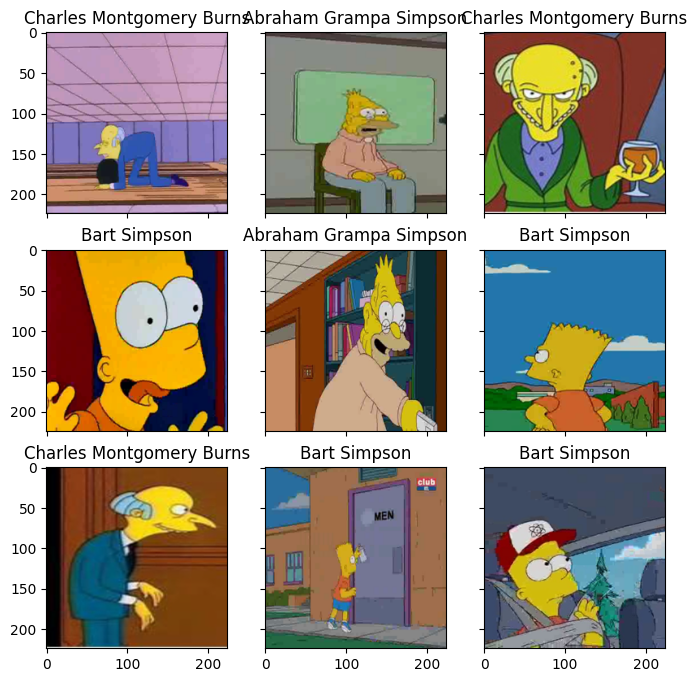

In [31]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [32]:
# Очень простая сеть
class SimpleCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.Linear(96 * 5 * 5, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [33]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [34]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [35]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [36]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [37]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_fea

Запустим обучение сети.

In [38]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

In [39]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=2, batch_size=64)

epoch:   0%|          | 0/2 [00:00<?, ?it/s]

loss 2.632228892930367


epoch:  50%|█████     | 1/2 [02:10<02:10, 130.66s/it]


Epoch 001 train_loss: 2.6322     val_loss 2.0155 train_acc 0.2643 val_acc 0.4559
loss 1.6369799131291316


epoch: 100%|██████████| 2/2 [04:16<00:00, 128.17s/it]


Epoch 002 train_loss: 1.6370     val_loss 1.3920 train_acc 0.5530 val_acc 0.6311


Построим кривые обучения

In [40]:
loss, acc, val_loss, val_acc = zip(*history)

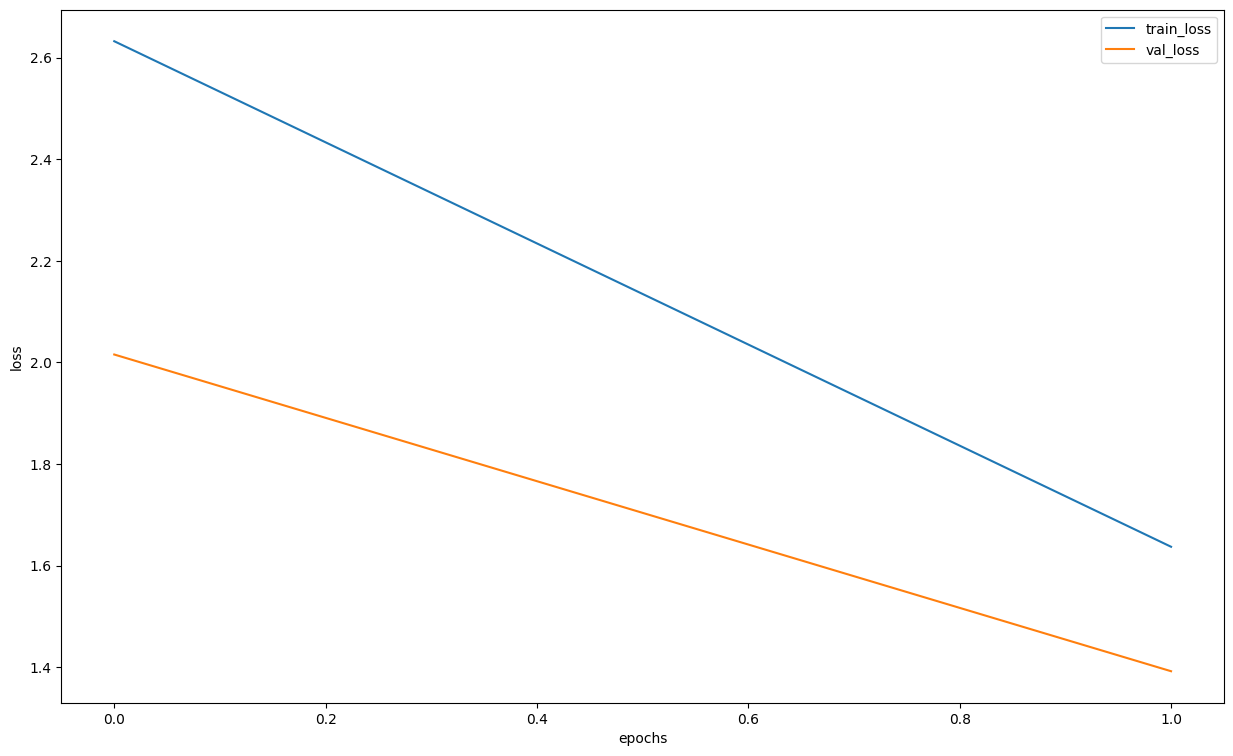

In [41]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит.
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [42]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [43]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [44]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [45]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [46]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [47]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)


F1-оценка: 0.65


Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

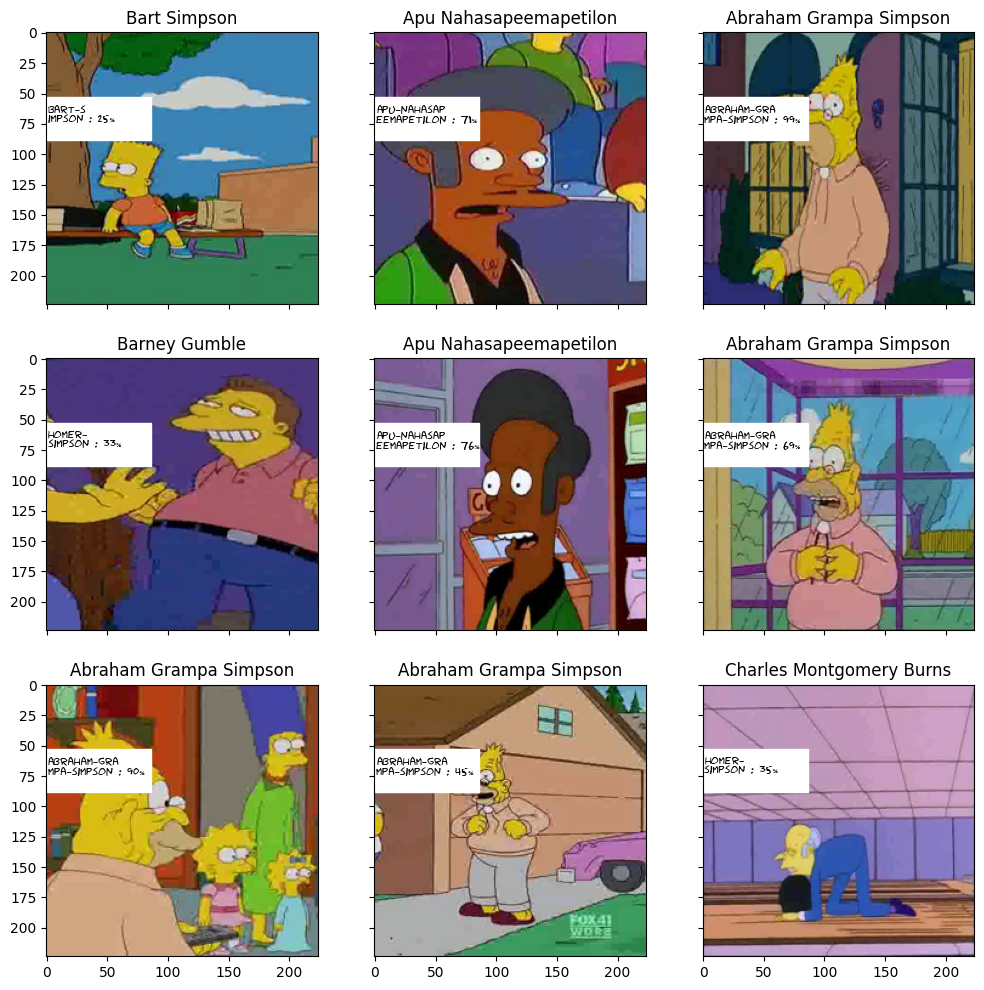

In [48]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [49]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [50]:
! ls

characters_illustration.png  label_encoder.pkl	sample_submission.csv  train
gdrive			     sample_data	testset


In [57]:
import pandas as pd
my_submit = pd.read_csv("/content/sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,lisa_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [54]:
my_submit.to_csv('/content/simple_cnn_baseline.csv', index=False)
# https://www.kaggle.com/competitions/journey-springfield/submissions

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать.

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову:


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)


In [58]:
def new_fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0  # Суммарная потеря на этапе обучения
    running_corrects = 0  # Количество правильно угаданных предсказаний
    processed_data = 0  # Общее количество обработанных данных

    for inputs, labels in train_loader:  # Проходимся по тренировочным данным
        inputs = inputs.to(DEVICE)  # Переносим входные данные на устройство (например, GPU)
        labels = labels.to(DEVICE)  # Переносим метки классов на устройство
        optimizer.zero_grad()  # Обнуляем градиенты

        outputs = model(inputs)  # Получаем выходы модели
        loss = criterion(outputs, labels)  # Вычисляем потерю
        loss.backward()  # Обратное распространение ошибки
        optimizer.step()  # Шаг оптимизатора
        preds = torch.argmax(outputs, 1)  # Получаем предсказанные классы
        running_loss += loss.item() * inputs.size(0)  # Обновляем суммарную потерю
        running_corrects += torch.sum(preds == labels.data)  # Обновляем количество правильных предсказаний
        processed_data += inputs.size(0)  # Обновляем количество обработанных данных

    train_loss = running_loss / processed_data  # Вычисляем среднюю потерю на этапе обучения
    train_acc = running_corrects.cpu().numpy() / processed_data  # Вычисляем точность на этапе обучения
    return train_loss, train_acc  # Возвращаем среднюю потерю и точность


In [59]:
def new_eval_epoch(model, val_loader, criterion):
    model.eval()  # Переводим модель в режим оценки
    running_loss = 0.0  # Суммарная потеря на этапе оценки
    running_corrects = 0  # Количество правильно угаданных предсказаний
    processed_size = 0  # Общее количество обработанных данных

    for inputs, labels in val_loader:  # Проходимся по валидационным данным
        inputs = inputs.to(DEVICE)  # Переносим входные данные на устройство
        labels = labels.to(DEVICE)  # Переносим метки классов на устройство

        with torch.set_grad_enabled(False):  # Отключаем вычисление градиентов
            outputs = model(inputs)  # Получаем выходы модели
            loss = criterion(outputs, labels)  # Вычисляем потерю
            preds = torch.argmax(outputs, 1)  # Получаем предсказанные классы

        running_loss += loss.item() * inputs.size(0)  # Обновляем суммарную потерю
        running_corrects += torch.sum(preds == labels.data)  # Обновляем количество правильных предсказаний
        processed_size += inputs.size(0)  # Обновляем количество обработанных данных

    val_loss = running_loss / processed_size  # Вычисляем среднюю потерю на этапе оценки
    val_acc = running_corrects.double() / processed_size  # Вычисляем точность на этапе оценки
    return val_loss, val_acc  # Возвращаем среднюю потерю и точность


In [60]:
def train(train_files, val_files, model, epochs, batch_size):
    # Создание DataLoader для тренировочного и валидационного наборов данных
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # DataLoader для тренировочных данных
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # DataLoader для валидационных данных

    history = []  # История обучения
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"  # Шаблон для вывода логов

    with tqdm(desc="epoch", total=epochs) as pbar_outer:  # Прогресс-бар для отображения прогресса обучения
        opt = torch.optim.Adam(model.parameters(), lr=10e-5)  # Оптимизатор Adam
        criterion = nn.CrossEntropyLoss()  # Функция потерь CrossEntropyLoss

        for epoch in range(epochs):  # Проходимся по всем эпохам обучения
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)  # Обучаем модель на тренировочных данных
            print("loss", train_loss)  # Выводим значение потери на этапе обучения

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)  # Оцениваем модель на валидационных данных
            history.append((train_loss, train_acc, val_loss, val_acc))  # Добавляем данные об эпохе в историю обучения

            pbar_outer.update(1)  # Обновляем прогресс-бар
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))  # Выводим логи обучения

    return history  # Возвращаем историю обучения


In [61]:
def mean_std(loader):
    sum, squared_sum, num_batches = 0, 0, 0
    for data, _ in loader:  # Проходимся по данным в DataLoader
        sum += torch.mean(data, dim=[0, 2, 3])  # Суммируем средние значения по измерениям пакета, высоты и ширины
        squared_sum += torch.mean(data ** 2, dim=[0, 2, 3])  # Суммируем квадраты значений по измерениям пакета, высоты и ширины
        num_batches += 1  # Увеличиваем счетчик пакетов
    mean = sum / num_batches  # Вычисляем среднее значение
    std = (squared_sum / num_batches - mean ** 2) ** 0.5  # Вычисляем стандартное отклонение
    return mean, std  # Возвращаем среднее значение и стандартное отклонение

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)  # DataLoader для тренировочных данных
mean, std = mean_std(train_loader)  # Вычисляем среднее значение и стандартное отклонение для тренировочных данных

class experimental_dataset(Dataset):
    def __init__(self, data, transform):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)  # Возвращаем длину набора данных

    def __getitem__(self, idx):
        item = self.data[idx]  # Получаем элемент по индексу
        item = self.transform(item)  # Применяем преобразование
        return item  # Возвращаем преобразованный элемент

transform = transforms.Compose([
    transforms.ToPILImage(),  # Преобразуем тензор в изображение PIL
    transforms.RandomHorizontalFlip(),  # Случайное горизонтальное отражение
    transforms.ToTensor(),  # Преобразуем изображение в тензор
    transforms.Normalize(mean, std)  # Нормализуем тензор с использованием средних значений и стандартных отклонений
])

transformed_train_dataset = experimental_dataset(train_dataset, transform)  # Применяем преобразования к тренировочному набору данных
transformed_val_dataset = experimental_dataset(val_dataset, transform)  # Применяем преобразования к валидационному набору данных


In [62]:
class MyCnn(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        # Первый сверточный слой
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),  # Входные каналы: 3, Выходные каналы: 8, Размер ядра: 3x3
            nn.BatchNorm2d(8),  # Нормализация по мини-пакетам
            nn.ReLU(),  # Функция активации ReLU
            nn.MaxPool2d(kernel_size=2)  # Слой максимальной пулинга с размером пула 2x2
        )
        # Второй сверточный слой
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),  # Входные каналы: 8, Выходные каналы: 16, Размер ядра: 3x3
            nn.BatchNorm2d(16),  # Нормализация по мини-пакетам
            nn.ReLU(),  # Функция активации ReLU
            nn.MaxPool2d(kernel_size=2)  # Слой максимальной пулинга с размером пула 2x2
        )
        # Третий сверточный слой
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),  # Входные каналы: 16, Выходные каналы: 32, Размер ядра: 3x3
            nn.BatchNorm2d(32),  # Нормализация по мини-пакетам
            nn.ReLU(),  # Функция активации ReLU
            nn.MaxPool2d(kernel_size=2)  # Слой максимальной пулинга с размером пула 2x2
        )
        # Четвертый сверточный слой
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),  # Входные каналы: 32, Выходные каналы: 64, Размер ядра: 3x3
            nn.BatchNorm2d(64),  # Нормализация по мини-пакетам
            nn.ReLU(),  # Функция активации ReLU
            nn.MaxPool2d(kernel_size=2)  # Слой максимальной пулинга с размером пула 2x2
        )
        # Пятый сверточный слой
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),  # Входные каналы: 64, Выходные каналы: 96, Размер ядра: 3x3
            nn.BatchNorm2d(96),  # Нормализация по мини-пакетам
            nn.ReLU(),  # Функция активации ReLU
            nn.MaxPool2d(kernel_size=2)  # Слой максимальной пулинга с размером пула 2x2
        )
        # Выходной линейный слой
        self.out = nn.Linear(96 * 5 * 5, n_classes)  # Входные признаки: 96*5*5, Выходные признаки: n_classes

    def forward(self, x):
        x = self.conv1(x)  # Применяем первый сверточный слой
        x = self.conv2(x)  # Применяем второй сверточный слой
        x = self.conv3(x)  # Применяем третий сверточный слой
        x = self.conv4(x)  # Применяем четвертый сверточный слой
        x = self.conv5(x)  # Применяем пятый сверточный слой
        x = x.view(x.size(0), -1)  # Выпрямляем данные перед подачей на полносвязный слой
        logits = self.out(x)  # Получаем выходные значения
        return logits  # Возвращаем выходные значения (логиты)


In [76]:
n_classes = len(np.unique(train_val_labels))
my_cnn = MyCnn(n_classes).to(DEVICE)
print(f"Classes to clasify :{n_classes}")
print(my_cnn)

Classes to clasify :42
MyCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [77]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print(f"Classes to clasify :{n_classes}")
print(simple_cnn)

Classes to clasify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_f

In [66]:
history = train(transformed_train_dataset, transformed_val_dataset, model=my_cnn, epochs=15, batch_size=128)

epoch:   0%|          | 0/15 [00:00<?, ?it/s]

loss 1.5991267786564223


epoch:   7%|▋         | 1/15 [02:12<30:48, 132.04s/it]


Epoch 001 train_loss: 1.5991     val_loss 1.5932 train_acc 0.5718 val_acc 0.5724
loss 1.3730483999813625


epoch:  13%|█▎        | 2/15 [04:36<30:10, 139.30s/it]


Epoch 002 train_loss: 1.3730     val_loss 1.4474 train_acc 0.6251 val_acc 0.6095
loss 1.2092504872965337


epoch:  20%|██        | 3/15 [07:03<28:32, 142.74s/it]


Epoch 003 train_loss: 1.2093     val_loss 1.3652 train_acc 0.6645 val_acc 0.6288
loss 1.0902054414330595


epoch:  27%|██▋       | 4/15 [09:11<25:07, 137.04s/it]


Epoch 004 train_loss: 1.0902     val_loss 1.2981 train_acc 0.6956 val_acc 0.6511
loss 0.971904614498087


epoch:  33%|███▎      | 5/15 [11:15<22:02, 132.29s/it]


Epoch 005 train_loss: 0.9719     val_loss 1.2076 train_acc 0.7288 val_acc 0.6741
loss 0.8718944325235377


epoch:  40%|████      | 6/15 [13:20<19:29, 129.90s/it]


Epoch 006 train_loss: 0.8719     val_loss 1.1674 train_acc 0.7591 val_acc 0.6911
loss 0.7949096920672659


epoch:  47%|████▋     | 7/15 [15:31<17:21, 130.19s/it]


Epoch 007 train_loss: 0.7949     val_loss 1.1357 train_acc 0.7775 val_acc 0.6989
loss 0.708175212936467


epoch:  53%|█████▎    | 8/15 [17:39<15:06, 129.50s/it]


Epoch 008 train_loss: 0.7082     val_loss 1.0818 train_acc 0.8032 val_acc 0.7191
loss 0.6246691146385321


epoch:  60%|██████    | 9/15 [19:49<12:57, 129.65s/it]


Epoch 009 train_loss: 0.6247     val_loss 1.0855 train_acc 0.8258 val_acc 0.7147
loss 0.5568827788111009


epoch:  67%|██████▋   | 10/15 [21:57<10:45, 129.08s/it]


Epoch 010 train_loss: 0.5569     val_loss 1.0641 train_acc 0.8454 val_acc 0.7308
loss 0.49764600311869217


epoch:  73%|███████▎  | 11/15 [24:06<08:36, 129.11s/it]


Epoch 011 train_loss: 0.4976     val_loss 1.0499 train_acc 0.8637 val_acc 0.7350
loss 0.44383540950206307


epoch:  80%|████████  | 12/15 [26:10<06:22, 127.57s/it]


Epoch 012 train_loss: 0.4438     val_loss 1.0255 train_acc 0.8793 val_acc 0.7468
loss 0.38967123493638584


epoch:  87%|████████▋ | 13/15 [28:14<04:12, 126.35s/it]


Epoch 013 train_loss: 0.3897     val_loss 1.0252 train_acc 0.8967 val_acc 0.7430
loss 0.3381068954950564


epoch:  93%|█████████▎| 14/15 [30:17<02:05, 125.48s/it]


Epoch 014 train_loss: 0.3381     val_loss 1.0661 train_acc 0.9105 val_acc 0.7465
loss 0.2983711614518555


epoch: 100%|██████████| 15/15 [32:23<00:00, 129.54s/it]


Epoch 015 train_loss: 0.2984     val_loss 1.0280 train_acc 0.9207 val_acc 0.7583


In [67]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(my_cnn, ex_img.unsqueeze(0))

In [68]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(my_cnn, imgs)

In [69]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [70]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [71]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)

F1-оценка: 0.65


In [72]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=128)
probs = predict(my_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [73]:
! ls

characters_illustration.png  label_encoder.pkl	sample_submission.csv	 testset
gdrive			     sample_data	simple_cnn_baseline.csv  train


In [74]:
import pandas as pd
my_submit = pd.read_csv("/content/sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [75]:
my_submit.to_csv('my_cnn_baseline.csv', index=False)


In [ ]:
# https://www.kaggle.com/mxteen